# Adversarial Robustness Experiments (CIFAR-10)
## Vergleich mehrerer Architekturen (LeNet, …) + FGSM Robustness

Dieses Notebook trainiert verschiedene Modelle auf CIFAR-10, evaluiert Clean-Accuracy und Robustheit unter FGSM (mehrere ε) und erstellt qualitative sowie quantitative Plots.


## 1) Imports, Vorbereitungen, Konstanten & Pfade Imports, Vorbereitungen, Konstanten & Pfade

### Git & Drive
- Repository mounten/öffnen
- Google Drive mounten (falls nötig)

In [1]:
# === Clone Git repository ===
!rm -rf /content/Bachelorarbeit-CIFAR10
!git clone https://github.com/crunchy-monster/Bachelorarbeit-CIFAR10.git

# Wechsel ins Repo
%cd /content/Bachelorarbeit-CIFAR10
!pwd


Cloning into 'Bachelorarbeit-CIFAR10'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 77 (delta 41), reused 58 (delta 22), pack-reused 0 (from 0)
Receiving objects: 100% (77/77), 143.02 KiB | 1.88 MiB/s, done.
Resolving deltas: 100% (41/41), done.
/content/Bachelorarbeit-CIFAR10
/content/Bachelorarbeit-CIFAR10


In [2]:
# Repo neue Änderungen holen

%cd /content/Bachelorarbeit-CIFAR10/Bachelorarbeit-CIFAR10
!git pull


[Errno 2] No such file or directory: '/content/MyDrive/Bachelorarbeit-CIFAR10/Bachelorarbeit-CIFAR10'
/content/Bachelorarbeit-CIFAR10
Already up to date.


In [3]:
# --- Python Pfad setzen

import sys
sys.path.append("/content/Bachelorarbeit-CIFAR10")


In [4]:
# --- Mount Drive

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [6]:
# --- Device + Pfade

import os, torch
from datetime import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

REPO_DIR = "/content/MyDrive/Bachelorarbeit-CIFAR10"
ARTIFACTS_DIR = "/content/drive/MyDrive/1/Bachelorarbeit-CIFAR10_artifacts"


RUN_ID = datetime.now().strftime("%Y%m%d_%H%M%S")

DATA_DIR   = "/content/data"  # schnell, darf weg sein
MODEL_DIR  = os.path.join(ARTIFACTS_DIR, "models")
RUNS_DIR   = os.path.join(ARTIFACTS_DIR, "runs")

for d in [DATA_DIR, MODEL_DIR, RUNS_DIR]:
    os.makedirs(d, exist_ok=True)

print("REPO_DIR:", REPO_DIR)
print("ARTIFACTS_DIR:", ARTIFACTS_DIR)


Device: cpu
REPO_DIR: /content/MyDrive/Bachelorarbeit-CIFAR10
ARTIFACTS_DIR: /content/drive/MyDrive/1/Bachelorarbeit-CIFAR10_artifacts


In [22]:
# --- Hyperparameter + Seeds (einheitlich für alle Modelle)

import random, numpy as np

BATCH_SIZE   = 64      # CPU often faster than 32; keep same for all models
LR           = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS       = 25      # oder 50 – je nach Zeit
PATIENCE     = 10
MIN_DELTA    = 1e-3
NUM_WORKERS  = 0       # in Colab CPU oft stabil; ggf. 2 testen
VAL_SPLIT    = 0.1
SEED         = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

print("BATCH_SIZE:", BATCH_SIZE, "EPOCHS:", EPOCHS)


BATCH_SIZE: 64 EPOCHS: 25


In [11]:
%cd /content/Bachelorarbeit-CIFAR10

/content/Bachelorarbeit-CIFAR10


In [13]:
import importlib

import data as data_module
import train_eval as train_eval_module

importlib.reload(data_module)
importlib.reload(train_eval_module)

from data import get_cifar10_loaders
from train_eval import train_model, eval_clean

from models.lenet import LeNet5_CIFAR10
from models.vgg16 import VGG16_CIFAR10
from models.resnet34 import ResNet34_CIFAR10


In [16]:
# --- DataLoader (Train/Val/Test)

trainloader, valloader, testloader = get_cifar10_loaders(
    batch_size=BATCH_SIZE,
    root=DATA_DIR,
    num_workers=NUM_WORKERS,
    val_ratio=VAL_SPLIT,
    seed=SEED
)

print("Train batches:", len(trainloader), "Val batches:", len(valloader), "Test batches:", len(testloader))


Train batches: 704 Val batches: 79 Test batches: 157


In [26]:

# --- Modell wählen ---
model_name = "vgg16"   # "lenet5" | "vgg16" | "resnet34"

if model_name == "lenet5":
    model = LeNet5_CIFAR10().to(device)
elif model_name == "vgg16":
    model = VGG16_CIFAR10(num_classes=10, dropout=0.0).to(device)
elif model_name == "resnet34":
    model = ResNet34_CIFAR10(num_classes=10).to(device)
else:
    raise ValueError("Unknown model_name")

print("Selected model:", model_name)
print("Model device:", next(model.parameters()).device)


Selected model: vgg16
Model device: cpu


In [27]:
# --- Run-Verzeichnis + Logging/Checkpoint-Pfade

model_name =f"{model_name}_{EPOCHS}ep"

RUN_DIR  = os.path.join(RUNS_DIR, f"{model_name}_{RUN_ID}")
CKPT_DIR = os.path.join(RUN_DIR, "checkpoints")

LOG_CSV  = os.path.join(RUN_DIR, f"{model_name}_metrics.csv")
LOG_JSON = os.path.join(RUN_DIR, f"{model_name}_history.json")

os.makedirs(RUN_DIR, exist_ok=True)
os.makedirs(CKPT_DIR, exist_ok=True)

print("RUN_DIR:", RUN_DIR)


RUN_DIR: /content/drive/MyDrive/1/Bachelorarbeit-CIFAR10_artifacts/runs/vgg16_25ep_20260113_163625


In [ ]:
# --- Training starten

history = train_model(
    model=model,
    train_loader=trainloader,
    val_loader=valloader,
    device=device,
    epochs=EPOCHS,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    early_stopping=True,
    patience=PATIENCE,
    min_delta=MIN_DELTA,
    ckpt_dir=CKPT_DIR,
    run_name=model_name,
    resume=True,
    log_csv_path=LOG_CSV,
    log_json_path=LOG_JSON
)

print("Training done. Best epoch:", history.get("best_epoch"), "Best val_loss:", history.get("best_val_loss"))


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Train 1/25:   0%|          | 0/704 [00:00<?, ?it/s]

In [20]:
# --- Bestes Modell exportieren

MODEL_PATH = os.path.join(MODEL_DIR, f"{model_name}.pt")
torch.save(model.state_dict(), MODEL_PATH)
print("Saved BEST model to:", MODEL_PATH)
print("Metric log CSV:", LOG_CSV)


Saved BEST model to: /content/drive/MyDrive/1/Bachelorarbeit-CIFAR10_artifacts/models/lenet5_3ep.pt
Metric log CSV: /content/drive/MyDrive/1/Bachelorarbeit-CIFAR10_artifacts/runs/lenet5_3ep_20260113_163625/lenet5_3ep_metrics.csv


In [21]:
# --- finaler Clean-Test-Check

test_loss, test_acc = eval_clean(model, testloader, device)
print(f"[FINAL CLEAN TEST] loss={test_loss:.4f} | acc={test_acc:.2f}%")


[FINAL CLEAN TEST] loss=1.3199 | acc=53.05%


# Old

In [ ]:
# Drive “hart” resetten, nur wenn Mount spinnt
!fusermount -u /content/drive 2>/dev/null || true
!rm -rf /content/drive 2>/dev/null || true
!mkdir -p /content/drive


In [ ]:
# Drive mounten

from google.colab import drive
drive.mount("/content/drive", force_remount=True)


ValueError: mount failed

In [ ]:
# Repo clonen

%cd /content/drive/MyDrive/Bachelorarbeit-CIFAR10
!git clone https://github.com/crunchy-monster/Bachelorarbeit-CIFAR10.git




/content/drive/MyDrive/Bachelorarbeit-CIFAR10
fatal: destination path 'Bachelorarbeit-CIFAR10' already exists and is not an empty directory.


In [ ]:
# Repo neue Änderungen holen

%cd /content/drive/MyDrive/Bachelorarbeit-CIFAR10/Bachelorarbeit-CIFAR10
!git pull


/content/drive/MyDrive/Bachelorarbeit-CIFAR10/Bachelorarbeit-CIFAR10
Already up to date.


In [ ]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [ ]:
# --- System / Utils ---
import random, json
import numpy as np
import matplotlib.pyplot as plt
import os, torch
from datetime import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# --- Paths ---
REPO_DIR = "/content/drive/MyDrive/Bachelorarbeit-CIFAR10"
ARTIFACTS_DIR = os.path.join(REPO_DIR, "artifacts")

RUN_ID = datetime.now().strftime("%Y%m%d_%H%M%S")

#DATA_DIR   = os.path.join(ARTIFACTS_DIR, "data")
DATA_DIR   = os.path.join("/content/data")
MODEL_DIR  = os.path.join(ARTIFACTS_DIR, "models")
RESULT_DIR = os.path.join(ARTIFACTS_DIR, "results")
PLOT_DIR   = os.path.join(ARTIFACTS_DIR, "plots")
RUNS_DIR   = os.path.join(ARTIFACTS_DIR, "runs")



for d in [DATA_DIR, MODEL_DIR, RESULT_DIR, PLOT_DIR, RUNS_DIR]:
    os.makedirs(d, exist_ok=True)

print("REPO_DIR:", REPO_DIR)
print("ARTIFACTS_DIR:", ARTIFACTS_DIR)
!pwd




Device: cpu
REPO_DIR: /content/drive/MyDrive/Bachelorarbeit-CIFAR10
ARTIFACTS_DIR: /content/drive/MyDrive/Bachelorarbeit-CIFAR10/artifacts
/content/drive/MyDrive/Bachelorarbeit-CIFAR10/Bachelorarbeit-CIFAR10


In [ ]:
# --- Hyperparameter setzen ---

BATCH_SIZE = 64
LR = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 20
PATIENCE = 10
MIN_DELTA = 5e-4  # https://xgboosting.com/configure-xgboost-early-stopping-tolerance/
NUM_WORKERS = 0

# --- Repro ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# --- FGSM epsilons ---
EPSILONS = [1/255, 2/255, 4/255, 8/255]

## Vorbereitung

## Restliche Bibliotheken laden

In [ ]:
%cd /content/drive/MyDrive/Bachelorarbeit-CIFAR10/Bachelorarbeit-CIFAR10



import importlib


# Imports
# https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# 1) Load and normalize CIFAR10
# https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

from models.lenet import LeNet5_CIFAR10
from models.vgg16 import VGG16_CIFAR10
from models.resnet34 import ResNet34_CIFAR10

import data as data
import train_eval as train_eval
import plots as plots

importlib.reload(train_eval)
importlib.reload(plots)
importlib.reload(data)


from data import show_first_images, get_cifar10_loaders, CLASSES  # show_first_images nur, wenn vorhanden!
from train_eval import train_model, save_history, test_final, test_fgsm, eval_clean, eval_fgsm, load_history_csv
from plots import get_predictions, plot_confusion_matrix, plot_confidence_hist, predict_probs, show_clean_vs_fgsm, plot_training_curves, fgsm_single_image_demo



importlib.reload(data)
importlib.reload(train_eval)
importlib.reload(plots)

/content/drive/MyDrive/Bachelorarbeit-CIFAR10/Bachelorarbeit-CIFAR10


<module 'plots' from '/content/drive/MyDrive/Bachelorarbeit-CIFAR10/Bachelorarbeit-CIFAR10/plots.py'>

## 2) CIFAR-10 Download


get some random training images
https://github.com/pravalikaarunkumar/Comprehensive-CNN-Study-on-CIFAR10/blob/main/cnn_variants.ipynb
Ausgabe der ersten Bilder des Datasets
https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Downloading the data

In [ ]:
# Lade Daten (kein erneuter Download, falls schon vorhanden)
#train_loader, val_loader, test_loader = get_cifar10_loaders( root=DATA_DIR,batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, val_ratio=0.1, seed=SEED)


train_loader, val_loader, test_loader = get_cifar10_loaders(
    root=DATA_DIR,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    val_ratio=0.1,
    seed=SEED,
)

# Dataset für Visualisierung (Train-Subset)
train_dataset = train_loader.dataset

print("Train batches:", len(train_loader))
print("Test batches:", len(test_loader))

Train batches: 704
Test batches: 157


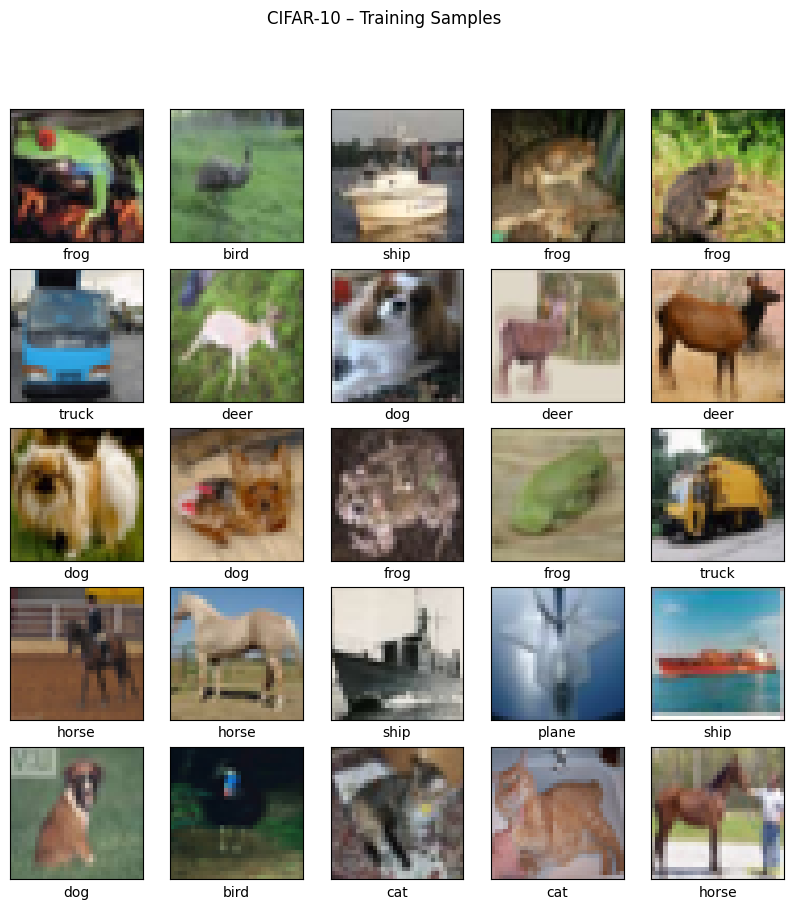

In [ ]:


# Zeige erste 25 Trainingsbilder
fig = show_first_images(train_dataset, CLASSES, n=25, title="CIFAR-10 – Training Samples")
fig.savefig(os.path.join(PLOT_DIR, "cifar10_first_images.png"), dpi=300, bbox_inches="tight")
plt.show()



## 3) LeNet5

### Training

In [ ]:
model_name = "lenet5_20ep"
model = LeNet5_CIFAR10().to(device)

print("Train batches per epoch:", len(train_loader))
print("Val batches:", len(val_loader))
print("Test batches:", len(test_loader))

Train batches per epoch: 1407
Val batches: 157
Test batches: 313


In [ ]:
print("Using device:", device)

os.makedirs(RUN_DIR, exist_ok=True)
os.makedirs(CKPT_DIR, exist_ok=True)
CKPT_DIR = os.path.join(RUN_DIR, "checkpoints")
LOG_CSV  = os.path.join(RUN_DIR, f"{model_name}_metrics.csv")
LOG_JSON = os.path.join(RUN_DIR, f"{model_name}_history.json")


history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=EPOCHS,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    early_stopping=True,
    patience=PATIENCE,
    min_delta=MIN_DELTA,
    ckpt_dir=CKPT_DIR,
    run_name="lenet5_20ep",
    resume=True,
    log_csv_path=LOG_CSV,
    log_json_path=LOG_JSON
)

# save BEST model (already restored)
MODEL_PATH = os.path.join(MODEL_DIR, f"{model_name}.pt")
torch.save(model.state_dict(), MODEL_PATH)
print("Saved:", MODEL_PATH)

Using device: cpu


Epochs:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train 1/4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 1/4 | train_loss=1.6467 | val_loss=1.5100 | val_acc=45.42% | lr=1.00e-03 | time=44.08s


Train 2/4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 2/4 | train_loss=1.4118 | val_loss=1.3885 | val_acc=51.80% | lr=1.00e-03 | time=43.36s


Train 3/4:   0%|          | 0/1407 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Epochen speichern in CSV/JSON

json_path, csv_path = save_history(history, out_dir=RESULT_DIR, run_name=model_name)
print("Saved:", json_path)
print("Saved:", csv_path)

Saved: /content/drive/MyDrive/Bachelorarbeit-CIFAR10/artifacts/results/lenet5_cifar10_full_model_3ep_history.json
Saved: /content/drive/MyDrive/Bachelorarbeit-CIFAR10/artifacts/results/lenet5_cifar10_full_model_3ep_history.csv


In [ ]:

# Lade history csv
csv_path = os.path.join(RESULT_DIR, f"{model_name}_history.csv")
history_loaded = load_history_csv(csv_path)

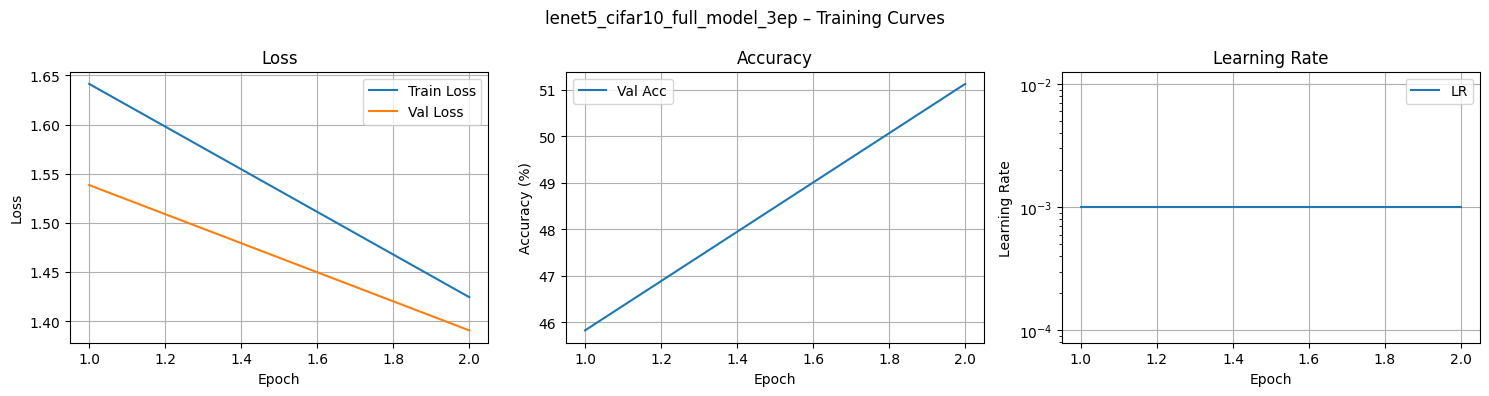

In [ ]:
# Plotte Training curves
fig = plot_training_curves(history_loaded, title=f"LeNet5 – Training Curves")
fig.savefig(os.path.join(PLOT_DIR, f"{model_name}_curves.png"), dpi=300, bbox_inches="tight")
plt.show()

### Evaluation des Models

In [ ]:
# --- Load model ---

# Modell aus Verzeichnis laden
MODEL_PATH = os.path.join(MODEL_DIR, f"{model_name}.pt")

model = LeNet5_CIFAR10().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

<All keys matched successfully>

In [ ]:
# --- Clean test ---

clean_loss, clean_acc = test_final(model, test_loader, device=device)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[CLEAN TEST] loss=1.3698 | acc=50.73%


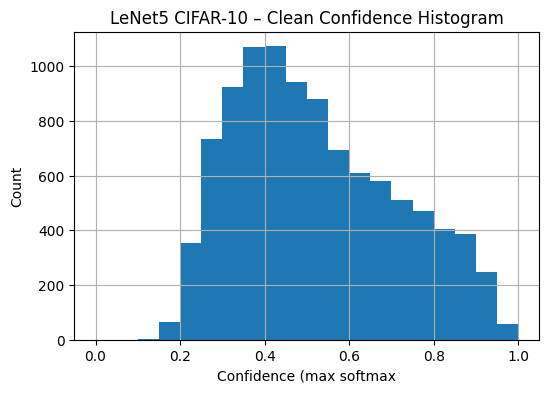

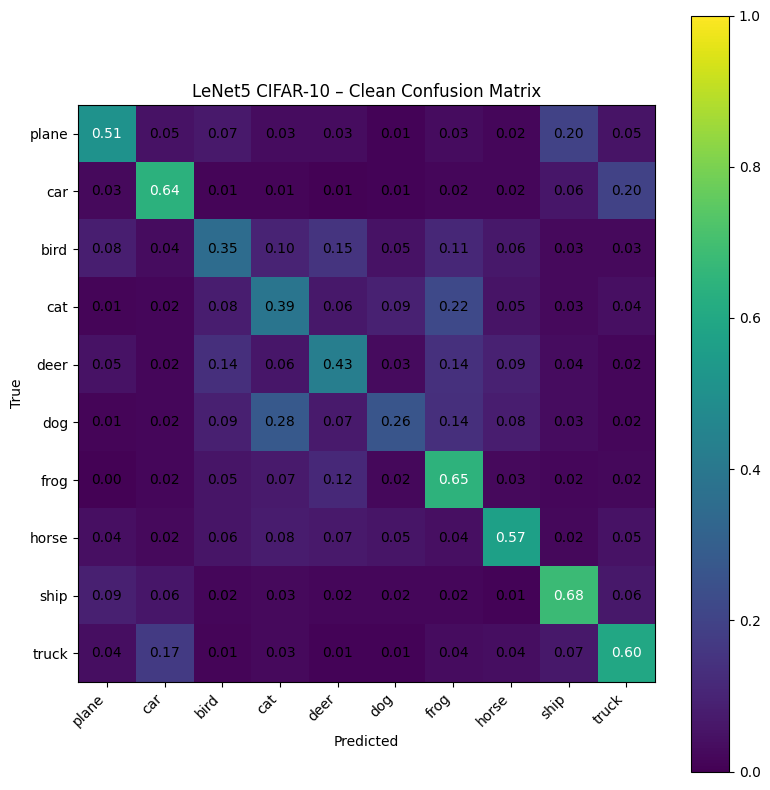

In [ ]:
# --- Clean predictions (for plots) ---
preds, labels, probs = get_predictions(model, test_loader, device)

# --- Clean Confidence Histogram (max softmax) ---
fig = plot_confidence_hist(probs, title="LeNet5 CIFAR-10 – Clean Confidence Histogram")
fig.savefig(os.path.join(PLOT_DIR, f"{model_name}_confidence.png"), dpi=300, bbox_inches="tight")
plt.show()

# --- Clean Confusion Matrix ---
fig = plot_confusion_matrix(preds, labels, CLASSES, title="LeNet5 CIFAR-10 – Clean Confusion Matrix")
fig.savefig(os.path.join(PLOT_DIR, f"{model_name}_confusion.png"), dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
# --- FGSM table (all eps) ---

fgsm_rows = []
for eps in EPSILONS:
    adv_loss, adv_acc = test_fgsm(model, test_loader, device=device, epsilon=eps)
    drop = clean_acc - adv_acc
    fgsm_rows.append({
        "epsilon": float(eps),
        "adv_loss": float(adv_loss),
        "adv_acc": float(adv_acc),
        "acc_drop": float(drop)
    })
    print(f"[FGSM] eps={eps:.5f} | loss={adv_loss:.4f} | acc={adv_acc:.2f}% | drop={drop:.2f}pp")


# Save results
out = {
    "model": model_name,
    "clean_loss": float(clean_loss),
    "clean_acc": float(clean_acc),
    "epsilons": [float(e) for e in EPSILONS],
    "fgsm": fgsm_rows
}

with open(os.path.join(RESULT_DIR, f"{model_name}_fgsm_results.json"), "w") as f:
    json.dump(out, f, indent=2)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[FGSM] eps=0.00392 | loss=1.4683 | acc=47.17% | drop=3.56pp
[FGSM] eps=0.00784 | loss=1.5698 | acc=43.28% | drop=7.45pp
[FGSM] eps=0.01569 | loss=1.7723 | acc=36.21% | drop=14.52pp
[FGSM] eps=0.03137 | loss=2.1445 | acc=25.85% | drop=24.88pp


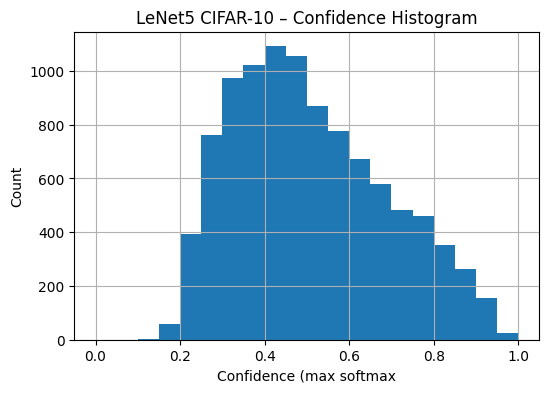

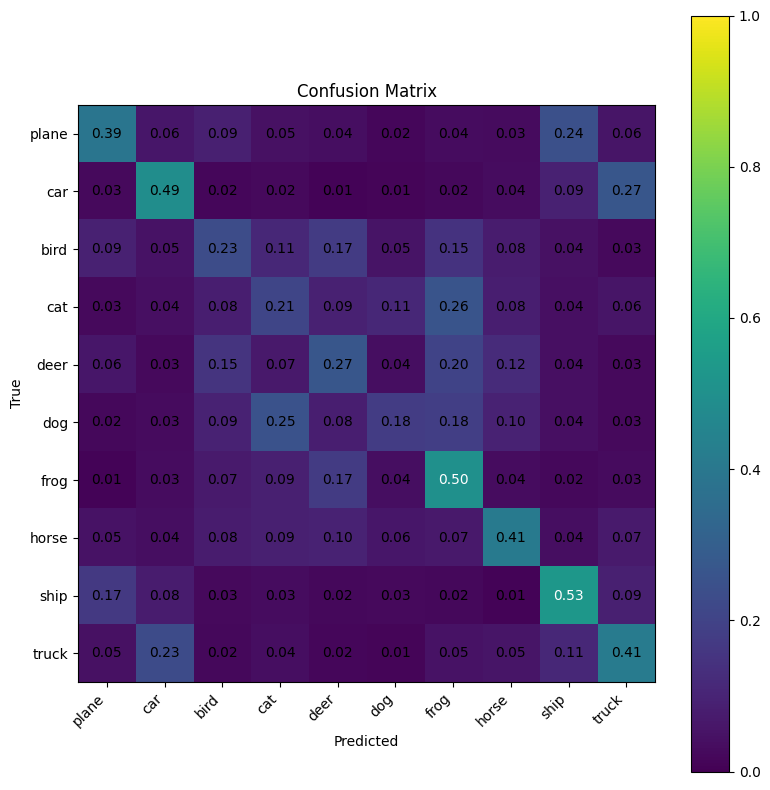

In [ ]:
# --- FGSM plots for ONE representative epsilon ---

EPS = 4/255
preds_adv, labels_adv, probs_adv = get_predictions(
    model, test_loader, device, attack=True, epsilon=EPS
)


# --- FGSM Confidence Histogram (max softmax) ---

fig = plot_confidence_hist(probs_adv, title="LeNet5 CIFAR-10 FGSM – Confidence Histogram")
fig.savefig(os.path.join(PLOT_DIR, f"{model_name}_fgsm_confidence.png"), dpi=300, bbox_inches="tight")
plt.show()

# --- FGSM Confusion Matrix ---
fig = plot_confusion_matrix(preds, labels, CLASSES, title="LeNet5 CIFAR-10 FGSM – Clean Confusion Matrix")
fig.savefig(os.path.join(PLOT_DIR, f"{model_name}_fgsm_confusion.png"), dpi=300, bbox_inches="tight")
plt.show()


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


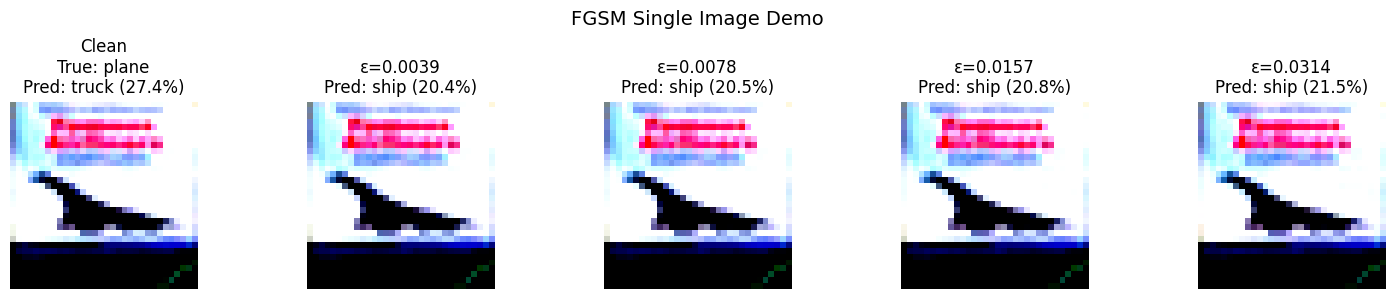

In [ ]:
# FGSM -Beispiel anzeigen

fig = fgsm_single_image_demo(
    model = model,
    test_loader=test_loader,
    device=device,
    epsilons=EPSILONS,
    class_names=CLASSES,
    idx=None,
    title =  "FGSM Single Image Demo"
)

fig.savefig(os.path.join(PLOT_DIR, f"{model_name}_fgsm_exampl.png"), dpi=300, bbox_inches="tight")
plt.show()

## VGG16

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VGG16_CIFAR10(num_classes=10).to(device)

model_name = "vgg16_30ep_64batch"

CKPT_DIR = os.path.join(RUNS_DIR, f"{model_name}_run1", "checkpoints")

history = train_model(
    model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=EPOCHS,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    early_stopping=True,
    patience=PATIENCE,
    min_delta=MIN_DELTA,
    ckpt_dir=CKPT_DIR,
    run_name="vgg16",
    resume=True
)



Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train 1/30:   0%|          | 0/704 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Training ab Checkpoint laden
model_name = "vgg16_30ep_64batch"

ckpt = torch.load(
    os.path.join(CKPT_DIR, "resnet_last.pt"),
    map_location=device
)

model.load_state_dict(ckpt["model_state"])
optimizer.load_state_dict(ckpt["optimizer_state"])
start_epoch = ckpt["epoch"] + 1
best_val_loss = ckpt["best_val_loss"]

In [ ]:
# ## best aus checkpoint ladden und exportieren
best_ckpt_path = os.path.join(CKPT_DIR, f"{model_name}_best.pt")
ckpt = torch.load(best_ckpt_path, map_location=device)
model.load_state_dict(ckpt["model_state"])
model.eval()


In [ ]:
MODEL_PATH = os.path.join(MODEL_DIR, f"{model_name}.pt")
torch.save(model.state_dict(), MODEL_PATH)
print("Saved:", MODEL_PATH)


In [ ]:
# Epochen speichern in CSV/JSON
json_path, csv_path = save_history(history, out_dir=RESULT_DIR, run_name=model_name)
print("Saved:", json_path)
print("Saved:", csv_path)


In [ ]:
# Lade history csv
csv_path = os.path.join(RESULT_DIR, f"{model_name}_history.csv")
history_loaded = load_history_csv(csv_path)

# Plotte Training curves
fig = plot_training_curves(history_loaded, title=f"{model_name} – VGG16 Training Curves")
fig.savefig(os.path.join(PLOT_DIR, f"{model_name}_curves.png"), dpi=300, bbox_inches="tight")
plt.show()


### Evaluation des Models

In [ ]:
# --- Load model ---

# Modell aus Verzeichnis laden
MODEL_PATH = os.path.join(MODEL_DIR, f"{model_name}.pt")

model = LeNet5_CIFAR10().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

In [ ]:
# --- Clean test ---

clean_loss, clean_acc = test_final(model, test_loader, device=device)


In [ ]:
# --- Clean predictions (for plots) ---
preds, labels, probs = get_predictions(model, test_loader, device)

# --- Clean Confidence Histogram (max softmax) ---
fig = plot_confidence_hist(probs, title="VGG16 CIFAR-10 – Clean Confidence Histogram")
fig.savefig(os.path.join(PLOT_DIR, f"{model_name}_confidence.png"), dpi=300, bbox_inches="tight")
plt.show()

# --- Clean Confusion Matrix ---
fig = plot_confusion_matrix(preds, labels, CLASSES, title="VGG16 CIFAR-10 – Clean Confusion Matrix")
fig.savefig(os.path.join(PLOT_DIR, f"{model_name}_confusion.png"), dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
# --- FGSM table (all eps) ---

fgsm_rows = []
for eps in EPSILONS:
    adv_loss, adv_acc = test_fgsm(model, test_loader, device=device, epsilon=eps)
    drop = clean_acc - adv_acc
    fgsm_rows.append({
        "epsilon": float(eps),
        "adv_loss": float(adv_loss),
        "adv_acc": float(adv_acc),
        "acc_drop": float(drop)
    })
    print(f"[FGSM] eps={eps:.5f} | loss={adv_loss:.4f} | acc={adv_acc:.2f}% | drop={drop:.2f}pp")


# Save results
out = {
    "model": model_name,
    "clean_loss": float(clean_loss),
    "clean_acc": float(clean_acc),
    "epsilons": [float(e) for e in EPSILONS],
    "fgsm": fgsm_rows
}

with open(os.path.join(RESULT_DIR, f"{model_name}_fgsm_results.json"), "w") as f:
    json.dump(out, f, indent=2)

In [ ]:
# --- FGSM plots for ONE representative epsilon ---

EPS = 4/255
preds_adv, labels_adv, probs_adv = get_predictions(
    model, test_loader, device, attack=True, epsilon=EPS
)


# --- FGSM Confidence Histogram (max softmax) ---

fig = plot_confidence_hist(probs_adv, title="LeNet5 CIFAR-10 – Confidence Histogram")
fig.savefig(os.path.join(PLOT_DIR, f"{model_name}_fgsm_confidence.png"), dpi=300, bbox_inches="tight")
plt.show()

# --- FGSM Confusion Matrix ---

fig = plot_confusion_matrix(preds_adv, labels_adv, CLASSES)
fig.savefig(os.path.join(PLOT_DIR, f"{model_name}_fgsm_confusion.png"), dpi=300, bbox_inches="tight")
plt.show()


## ResNet34

In [ ]:
# https://pyhopper.readthedocs.io/en/stable/examples/torch_cifar10.html

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet34_CIFAR10(num_classes=10).to(device)

model_name = "resnet34_20ep_64batch"

CKPT_DIR = os.path.join(RUNS_DIR, f"{model_name}_run1", "checkpoints")

history = train_model(
    model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=EPOCHS,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    early_stopping=True,
    patience=PATIENCE,
    min_delta=MIN_DELTA,
    ckpt_dir=CKPT_DIR,
    run_name="vgg16",
    resume=True
)


NameError: name 'torch' is not defined

In [ ]:
# Training ab Checkpoint laden
model_name = "resnet34_20ep_64batch"

ckpt = torch.load(
    os.path.join(CKPT_DIR, "vgg16_last.pt"),
    map_location=device
)

model.load_state_dict(ckpt["model_state"])
optimizer.load_state_dict(ckpt["optimizer_state"])
start_epoch = ckpt["epoch"] + 1
best_val_loss = ckpt["best_val_loss"]

In [ ]:
# save BEST model (already restored)
MODEL_PATH = os.path.join(MODEL_DIR, f"{model_name}.pt")
torch.save(model.state_dict(), MODEL_PATH)
print("Saved:", MODEL_PATH)

In [ ]:
# Epochen speichern in CSV/JSON

json_path, csv_path = save_history(history, out_dir=RESULT_DIR, run_name=model_name)
print("Saved:", json_path)
print("Saved:", csv_path)

In [ ]:

# Lade history csv
csv_path = os.path.join(RESULT_DIR, f"{model_name}_history.csv")
history_loaded = load_history_csv(csv_path)

In [ ]:
# Plotte Training curves
fig = plot_training_curves(history_loaded, title=f"{model_name} – Training Curves")
fig.savefig(os.path.join(PLOT_DIR, f"{model_name}_curves.png"), dpi=300, bbox_inches="tight")
plt.show()

### Evaluation des Models


In [ ]:
# --- Load model ---

# Modell aus Verzeichnis laden
MODEL_PATH = os.path.join(MODEL_DIR, "lenet5_cifar10_full_model_5ep.pt")

model = LeNet5_CIFAR10().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

NameError: name 'os' is not defined

In [ ]:
# --- Clean test ---

clean_loss, clean_acc = test_final(model, test_loader, device=device)


In [ ]:
# --- Clean predictions (for plots) ---
preds, labels, probs = get_predictions(model, test_loader, device)

# --- Clean Confidence Histogram (max softmax) ---
fig = plot_confidence_hist(probs, title="LeNet5 CIFAR-10 – Clean Confidence Histogram")
fig.savefig(os.path.join(PLOT_DIR, f"{model_name}_confidence.png"), dpi=300, bbox_inches="tight")
plt.show()

# --- Clean Confusion Matrix ---
fig = plot_confusion_matrix(preds, labels, CLASSES, title="LeNet5 CIFAR-10 – Clean Confusion Matrix")
fig.savefig(os.path.join(PLOT_DIR, f"{model_name}_confusion.png"), dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
# --- FGSM table (all eps) ---

fgsm_rows = []
for eps in EPSILONS:
    adv_loss, adv_acc = test_fgsm(model, test_loader, device=device, epsilon=eps)
    drop = clean_acc - adv_acc
    fgsm_rows.append({
        "epsilon": float(eps),
        "adv_loss": float(adv_loss),
        "adv_acc": float(adv_acc),
        "acc_drop": float(drop)
    })
    print(f"[FGSM] eps={eps:.5f} | loss={adv_loss:.4f} | acc={adv_acc:.2f}% | drop={drop:.2f}pp")


# Save results
out = {
    "model": model_name,
    "clean_loss": float(clean_loss),
    "clean_acc": float(clean_acc),
    "epsilons": [float(e) for e in EPSILONS],
    "fgsm": fgsm_rows
}

with open(os.path.join(RESULT_DIR, f"{model_name}_fgsm_results.json"), "w") as f:
    json.dump(out, f, indent=2)

In [ ]:
# --- FGSM plots for ONE representative epsilon ---

EPS = 4/255
preds_adv, labels_adv, probs_adv = get_predictions(
    model, test_loader, device, attack=True, epsilon=EPS
)


# --- FGSM Confidence Histogram (max softmax) ---

fig = plot_confidence_hist(probs_adv, title="LeNet5 CIFAR-10 – Confidence Histogram")
fig.savefig(os.path.join(PLOT_DIR, f"{model_name}_fgsm_confidence.png"), dpi=300, bbox_inches="tight")
plt.show()

# --- FGSM Confusion Matrix ---

fig = plot_confusion_matrix(preds_adv, labels_adv, CLASSES)
fig.savefig(os.path.join(PLOT_DIR, f"{model_name}_fgsm_confusion.png"), dpi=300, bbox_inches="tight")
plt.show()
